## Threshold Optimization

#### What is threshold optimization?

Threshold optimization is the process of choosing the best probability cutoff for converting a model's predicted probablitiy into a class decision, based on your actual objective (business or evaluation), instead of blindly using the default value (0.5).

In fraud detection tasks, the fraud rate ranges between 0.1% and 0.2%. In such cases, using the threshold as 0.5 leads to low precision and recall. 


**How does threshold optimization actually does?**
- Sweeps through all possible probability cutoffs
- Computes metrics at each cutoff
- Selects the cutoff that best matches the goals 

**When to use it?**
- When the data is imbalanced
- False positives and false negatives have different costs
- Based on models (logistic regression, Boosting algorithms, Neural networks)
- When you care about precision, recall, F1, or PR-AUC
- Multiple models have similar ROC-AUC

**When not to use it?**
- When the classes are balanced and costs are symmetric 
- You only care about ranking, not decisions (recommendation systems, search engines)

In [1]:
# imports and configurations 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.metrics import (
  precision_recall_curve,
  roc_auc_score,
  average_precision_score,
  precision_score,
  recall_score,
  f1_score,
  confusion_matrix
)

In [2]:
# load validation and test data

DATA_DIR = "../data/processed/"

X_val  = pd.read_parquet(DATA_DIR + "X_val.parquet")
y_val  = pd.read_parquet(DATA_DIR + "y_val.parquet").values.ravel()

X_test = pd.read_parquet(DATA_DIR + "X_test.parquet")
y_test = pd.read_parquet(DATA_DIR + "y_test.parquet").values.ravel()

In [3]:
import joblib 

MODEL_PATH = "../models/xgboost_model.joblib"
xgb_model = joblib.load(MODEL_PATH)

In [4]:
# get validation probabilities 
# threshold optimization always uses probabilities

y_val_proba = xgb_model.predict_proba(X_val)[:, 1]

In [5]:
# precision-recall curve 
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

In [6]:
# compute f1-score across thresholds 

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

#### Find the best/optimal threshold values 

In [7]:
## threshold value for maximum f1 

best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]

best_f1_threshold


np.float32(0.97583586)

In [8]:
# threshold for high recall 

target_recall = 0.90 

recall_idxs = np.where(recall >= target_recall)[0]
recall_threshold = thresholds[recall_idxs[-1]]

recall_threshold

np.float32(0.000119165656)

In [9]:
# threshold for high precision (>=95%)

target_precision = 0.95

precision_idxs = np.where(precision >= target_precision)[0]
precision_threshold = thresholds[precision_idxs[0]]

precision_threshold

np.float32(0.9977896)

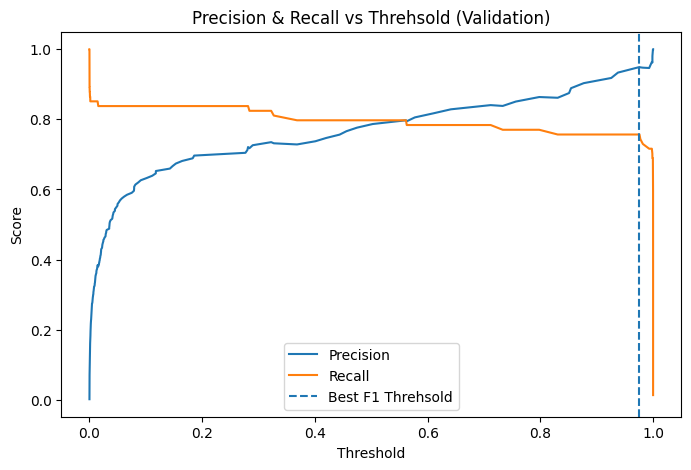

In [10]:
# Precision/Recall vs Threshold 

plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(best_f1_threshold, linestyle="--", label="Best F1 Threhsold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threhsold (Validation)")
plt.legend()
save_path = "../reports/figures/14_precision_recall_vs_threshold.png"  
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

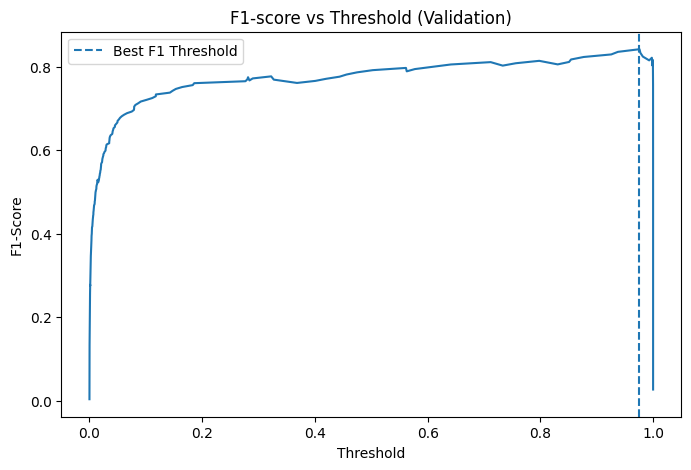

In [11]:
# F1-Score vs Threshold 

plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores[:-1])
plt.axvline(best_f1_threshold, linestyle="--", label="Best F1 Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("F1-score vs Threshold (Validation)")
plt.legend()
save_path = "../reports/figures/15_f1_score_vs_threshold.png"  
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [12]:
FINAL_THRESHOLD = best_f1_threshold

In [13]:
y_val_pred = (y_val_proba >= FINAL_THRESHOLD).astype(int)

val_metrics = {
    "ROC-AUC": roc_auc_score(y_val, y_val_proba),
    "PR-AUC": average_precision_score(y_val, y_val_proba),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1-score": f1_score(y_val, y_val_pred),
    "Confusion Matrix": confusion_matrix(y_val, y_val_pred)
}

val_metrics


{'ROC-AUC': 0.9794320312762407,
 'PR-AUC': 0.8293173935303936,
 'Precision': 0.9491525423728814,
 'Recall': 0.7567567567567568,
 'F1-score': 0.8421052631578947,
 'Confusion Matrix': array([[42644,     3],
        [   18,    56]])}

In [14]:
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= FINAL_THRESHOLD).astype(int)

In [15]:
test_metrics = {
    "ROC-AUC": roc_auc_score(y_test, y_test_proba),
    "PR-AUC": average_precision_score(y_test, y_test_proba),
    "Precision": precision_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "F1-score": f1_score(y_test, y_test_pred),
    "Confusion Matrix": confusion_matrix(y_test, y_test_pred)
}

test_metrics


{'ROC-AUC': 0.9718167449948542,
 'PR-AUC': 0.8376340243931737,
 'Precision': 0.9655172413793104,
 'Recall': 0.7567567567567568,
 'F1-score': 0.8484848484848485,
 'Confusion Matrix': array([[42646,     2],
        [   18,    56]])}

In [17]:
final_artifact = {
    "model": xgb_model,
    "threshold": float(FINAL_THRESHOLD),
    "val_metrics": val_metrics,
    "test_metrics": test_metrics
}

joblib.dump(final_artifact, "../models/final_xgb_with_threshold.joblib")

['../models/final_xgb_with_threshold.joblib']

#### Why not try out more models?

1. Diminishing returns 

The `XGBoost` model has achieved PR-AUC = 0.84, Precision = 96.5%, and almost zero false positives. At this stage, any new model will improve metrics by <1-2%. These gains are often noise and are not significant. 

Each new model increases complexity, increases maintenance burden, and addes real value. In production, This is a bad trade-off. 

2. More models is not equal to better system 

The system is judged by stability, explainability, cost control, and operational impact. Adding more models will make the comparisons harder, encourages metric cherry-picking, and weakend reproducibility. 

Stop at XGBoost because PR-AUC gains plateaued.

### Why not tune hyperparameters?

1. Overfitting to the validation set 

Every tuning step uses information from the validation set, which slowly leaks validation knowledge into the models. Eventually the validation metric look great and the test performance degrades. 

2. Threshold optimization already gave the biggest gain 

Threshold tuning often gives more benefit than hyperparamater tuning in imbalanced problems. In this case, the precision jumped from ~30% to ~96%. 

Spending time on hyperparameter tuning for a <1%  ROC-AUC gain is inefficient. 

3. Cost vs benefit 

Hyperparameter tuning costs times, compute, debugging, and reproducibility. It is wise to optimise system performance at this stage. 